In [1]:
import cv2
import numpy as np
import json
import os
import pandas as pd
import PIL
from PIL import Image
from matplotlib import gridspec
from matplotlib import pyplot as plt

In [2]:
#@title Helper methods

class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, modelPath, isTarFile=False):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    if isTarFile:
    # Extract frozen graph from tar archive.
      tar_file = tarfile.open(modelPath)
      for tar_info in tar_file.getmembers():
        if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
          file_handle = tar_file.extractfile(tar_info)
          graph_def = tf.GraphDef.FromString(file_handle.read())
          break

      tar_file.close()
    else:
      with open(modelPath, 'rb') as file_handle:
        graph_def = tf.GraphDef.FromString(file_handle.read())


    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [6]:
os.chdir('/home/jovyan/AT073_10_Orig_Style/Libs/Tensorflow/models/data/thetiffanychen-2019-01-16/')

In [7]:
mydata = pd.DataFrame({'name':os.listdir()})
mydata['path'] = '/home/jovyan/AT073_10_Orig_Style/Libs/Tensorflow/models/data/thetiffanychen-2019-01-16/'+ mydata['name']
mydata['file'], mydata['doc_type'] = mydata['name'].str.split('.', 1).str
train_data = mydata[mydata['doc_type'].str.lower().eq('json')]
train_data.head()

,name,path,file,doc_type
0,46699771_498641113976013_3381317086197072542_n...,/home/jovyan/AT073_10_Orig_Style/Libs/Tensorfl...,46699771_498641113976013_3381317086197072542_n,json
3,45430641_1714076542061803_3865460001849434798_...,/home/jovyan/AT073_10_Orig_Style/Libs/Tensorfl...,45430641_1714076542061803_3865460001849434798_n,json
4,45752258_305616023616964_7783577835015879312_n...,/home/jovyan/AT073_10_Orig_Style/Libs/Tensorfl...,45752258_305616023616964_7783577835015879312_n,json
6,44864136_536118603558115_2462270706834139943_n...,/home/jovyan/AT073_10_Orig_Style/Libs/Tensorfl...,44864136_536118603558115_2462270706834139943_n,json
9,46303510_191029851842607_1118888060354375810_n...,/home/jovyan/AT073_10_Orig_Style/Libs/Tensorfl...,46303510_191029851842607_1118888060354375810_n,json


image 中有 1 個label
Height = 1080
Width = 1080
image 中有 1 個label
Height = 1080
Width = 1080
image 中有 2 個label
Height = 1080
Width = 1080
image 中有 2 個label
Height = 1080
Width = 1080
image 中有 0 個label
image 中有 4 個label
Height = 1080
Width = 1080
image 中有 1 個label
Height = 1080
Width = 1080
image 中有 0 個label
image 中有 2 個label
Height = 1080
Width = 1080
image 中有 4 個label
Height = 1080
Width = 1080
image 中有 2 個label
Height = 1080
Width = 1080
image 中有 4 個label
Height = 1023
Width = 1023
image 中有 13 個label
Height = 1080
Width = 1080
image 中有 1 個label
Height = 1080
Width = 1080
image 中有 1 個label
Height = 1080
Width = 1080
image 中有 3 個label
Height = 1080
Width = 1080
image 中有 4 個label
Height = 1080
Width = 1080
image 中有 1 個label
Height = 864
Width = 864
image 中有 2 個label
Height = 1080
Width = 1080
image 中有 5 個label
Height = 1080
Width = 1080
image 中有 1 個label
Height = 1248
Width = 1080
image 中有 4 個label
Height = 1080
Width = 1080
image 中有 2 個label
Height = 1079
Width = 1080
image 中有 1 個label
He

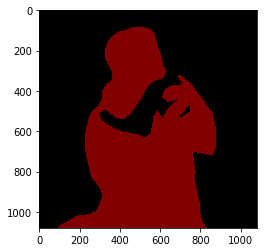

In [8]:
for mask_png in train_data['file']:
    json_data = open(mask_png + ".json").read()
    data = json.loads(json_data)

    if len(data['shapes']) == 0:
        print("image 中有",len(data['shapes']),"個label")
    else:
        print("image 中有",len(data['shapes']),"個label")       
        data['shapes'][0]
        Height = data['imageHeight']
        Width = data['imageWidth']
        print('Height =',data['imageHeight'])
        print('Width =',data['imageWidth'])

        person = []
        background = []

        for i in range(len(data['shapes'])):
            if data['shapes'][i].get('label') == 'person':
                person.append(np.array(data['shapes'][i]['points']).astype(int))
            elif data['shapes'][i].get('label') == 'background':
                background.append(np.array(data['shapes'][i]['points']).astype(int))
            else:
                print('other')
        
        org_img = np.zeros((Height,Width),dtype=np.uint8)
        for p in person:
            mask = cv2.fillPoly(org_img, [p], 1) #先畫人
        mask = cv2.fillPoly(mask, background, 0)  #再補空洞
        mask = mask.astype(np.int64)
        seg_image = label_to_color_image(mask).astype(np.uint8)
        plt.imshow(seg_image)
        img=PIL.Image.fromarray(seg_image)
        img.save(mask_png + '.png')

In [12]:
mask[:300]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])